In [31]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [32]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [33]:
import train_tabular_utils as tt
import cv_split_utils
import enums
from enums import ModelName
import data_utils
import param_tuning_utils as ptu

In [34]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "price"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSE
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.LGBM
    NUM_TUNING_TRIALS = 2
    TUNE_ON_SINGLE_FOLD = True
    TUNE_STEPWISE = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False    
    USE_MANUAL_FEATURES = True
    USE_ORIGINAL_DATA = True    
    FEATURE_SELECTION_METHOD = None
    NUM_CLASSES = None    

COLS_TO_LEAVE = ["id", "price", "kfold", "target_grp"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e9/"
    if Config.USE_MANUAL_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e9-fe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e9/"
    DATA_WRITEPATH = "/kaggle/working/"

In [73]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt",
        "device":  "cpu",
        #"gpu_platform_id": 0,
        #"gpu_device_id": 0
    },
    enums.ModelName.CatBoost: {
        "objective": "RMSE",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "RMSE",
        'grow_policy':  'Lossguide',
        'bootstrap_type': 'Poisson',
        'task_type': 'GPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [74]:
# For RandomForest
# tuned_model_params = {'n_estimators': 1300, 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}
# For CatBoost
# tuned_model_params = {'learning_rate': 0.01153083799677404, 'n_estimators': 1550, 'max_depth': 13, 'min_data_in_leaf': 63, 'num_leaves': 96, 'reg_lambda': 74.42786945287153, 'random_strength': 0.03782103405260509, 'early_stopping_rounds': 230, 'max_bin': 37}
# For XGBoost
# tuned_model_params = {'n_estimators': 1400, 'learning_rate': 0.10270166896064774, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 4.123490349502186, 'subsample': 0.5067185283456936, 'colsample_bytree': 0.7289930512882908, 'reg_alpha': 0.5971832077526927, 'reg_lambda': 9.433125479981229, 'early_stopping_rounds': 260}
# For LGBM
tuned_model_params = {'learning_rate': 0.04384599885192124, 'n_estimators': 1850, 'max_depth': 4, 'min_data_in_leaf': 79, 'num_leaves': 20, 'min_child_weight': 1.3000000000000003, 'subsample': 0.6909074597205864, 'colsample_bytree': 0.7928274099493369, 'reg_lambda': 178.39029552790532, 'reg_alpha': 1.704574120515208, 'early_stopping_rounds': 490, 'max_bin': 184}

# tuned_model_params = None

In [75]:
high_resale_price_brands = ['Mercedes-Benz', 'Bentley', 'Aston', 'Jaguar', 'Tesla', 'Lamborghini', 'Land', 'RAM', 
                            'Cadillac', 'Alfa', 'Ferrari', 'Porsche', 'Bugatti', 'McLaren', 'Rolls-Royce', 'Lucid', 
                            'Maserati', 'Rivian', 'Genesis']

In [76]:
if Config.USE_MANUAL_FEATURES and not Config.USE_ORIGINAL_DATA:
    df_train = pd.read_csv(DATA_READPATH + "train_preprocessed.csv")
    df_test = pd.read_csv(DATA_READPATH + "test_preprocessed.csv")        
    # remove rows where price > 2000000
    # df_train = df_train[df_train['price'] <= 2000000]
elif Config.USE_MANUAL_FEATURES and Config.USE_ORIGINAL_DATA:
    df_train = pd.read_csv(DATA_READPATH + "train_withorig_preprocessed.csv")
    df_test = pd.read_csv(DATA_READPATH + "test__with_orig_preprocessed.csv")
else:
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [77]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,horsepower,capacity,cylinders,fuel,turbo,hybrid,transmission_speed,transmission_type,age,is_high_resale_price_brand
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,172.0,1.6,4.0,gasoline,False,False,NaN,automatic,17,False
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,...,252.0,3.9,8.0,gasoline,False,False,NaN,automatic,22,False
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,320.0,5.3,8.0,flex,False,False,NaN,automatic,22,False
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,...,420.0,5.0,8.0,gasoline,False,False,NaN,Unknown,7,True
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,...,208.0,2.0,4.0,gasoline,False,False,7.0,automatic,3,True


In [78]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS,
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                n_bins=25)

In [79]:
imputation_config = None
if Config.USE_MANUAL_FEATURES:
    # Define imputation configuration
    imputation_config = {
        'horsepower': SimpleImputer(strategy="median"),
        'capacity': SimpleImputer(strategy="most_frequent"),
        'cylinders': SimpleImputer(strategy="most_frequent")
    }

In [80]:
df_train.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)
df_test.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)
if Config.USE_MANUAL_FEATURES:
    df_train.fillna({"fuel": "Unknown"})
    df_test.fillna({"fuel": "Unknown"})

In [81]:
# do not include 'id' column in the list of int columns
int_cols = [col for col in df_train.columns if df_train[col].dtypes == 'int64' and col not in COLS_TO_LEAVE]
float_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float64']
bool_cols = [col for col in df_train.columns if df_train[col].dtypes == 'bool']
cat_cols = [col for col in df_train.columns if df_train[col].dtypes == 'object' and col not in COLS_TO_LEAVE]
feature_cols = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [82]:
print(feature_cols)
print(cat_cols)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'horsepower', 'capacity', 'cylinders', 'fuel', 'turbo', 'hybrid', 'transmission_speed', 'transmission_type', 'age', 'is_high_resale_price_brand']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'fuel', 'transmission_type']


In [83]:
# Convert all categorical columns to string type
df_train[cat_cols] = df_train[cat_cols].astype(str)
cat_encoders = {col: [
                       OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                       TargetEncoder(target_type="continuous")  
                     ]
                    for col in cat_cols
                }

In [84]:
# # preprocessing
preprocessor = None
# scaler = StandardScaler()
# # onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
# preprocessor = ColumnTransformer(
#     transformers=[                
#         ("scaler", scaler, int_cols+float_cols),
#         #("onehot", onehot_encoder, int_features),                
#     ], remainder="passthrough"
# )

In [85]:
def get_lgbm_tuning_params(trial):    
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 200),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20)
    }
    return {**model_static_params[enums.ModelName.LGBM], **params_dynamic}

In [86]:
lgbm_level_params_totune = {
    "1": ["learning_rate", "n_estimators", "max_depth"],
    "2": ["min_data_in_leaf", "num_leaves", "min_child_weight"],
    "3": ["subsample", "colsample_bytree", "reg_lambda", "reg_alpha", "early_stopping_rounds", "max_bin"]
}

lgbm_param_ranges = {
    'learning_rate': {'type': 'float', 'min_value': 0.005, 'max_value': 0.3, 'log': True},
    'n_estimators': {'type': 'int', 'min_value': 500, 'max_value': 5000, 'step': 50},
    'max_depth': {'type': 'int', 'min_value': 4, 'max_value': 20},
    'min_data_in_leaf': {'type': 'int', 'min_value': 5, 'max_value': 100},
    'num_leaves': {'type': 'int', 'min_value': 4, 'max_value': 256, 'step': 4},
    'min_child_weight': {'type': 'float', 'min_value': 0.1, 'max_value': 10, 'step': 0.2},
    'subsample': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'colsample_bytree': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'reg_lambda': {'type': 'float', 'min_value': 1, 'max_value': 300},
    'reg_alpha': {'type': 'float', 'min_value': 0, 'max_value': 5},    
    'early_stopping_rounds': {'type': 'int', 'min_value': 50, 'max_value': 500, 'step': 20},
    'max_bin': {'type': 'int', 'min_value': 32, 'max_value': 255}
}

lgbm_params_defaults = {
    'max_depth': 5,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'min_child_weight': 1.0,
    'subsample': 0.8,    
    'colsample_bytree': 0.8,
    'reg_lambda': 3,
    'reg_alpha': 0,
    'random_strength': 1,
    'early_stopping_rounds': 100,
    'max_bin': 255
}

In [87]:
cb_level_params_totune = {
    "1": ["learning_rate", "n_estimators"],
    "2": ["max_depth", "min_data_in_leaf", "num_leaves"],
    "3": ["subsample", "reg_lambda", "random_strength", "early_stopping_rounds", "max_bin"]
}

cb_param_ranges = {
    'learning_rate': {'type': 'float', 'min_value': 1e-3, 'max_value': 0.5, 'log': True},
    'n_estimators': {'type': 'int', 'min_value': 500, 'max_value': 5000, 'step': 50},
    'max_depth': {'type': 'int', 'min_value': 4, 'max_value': 20},
    'min_data_in_leaf': {'type': 'int', 'min_value': 5, 'max_value': 100},
    'num_leaves': {'type': 'int', 'min_value': 4, 'max_value': 256, 'step': 4},
    'subsample': {'type': 'float', 'min_value': 0.5, 'max_value': 1},
    'reg_lambda': {'type': 'float', 'min_value': 1, 'max_value': 100},
    'random_strength': {'type': 'loguniform', 'min_value': 0.01, 'max_value': 10},
    'early_stopping_rounds': {'type': 'int', 'min_value': 50, 'max_value': 500, 'step': 20},
    'max_bin': {'type': 'int', 'min_value': 32, 'max_value': 255}
}

cb_params_defaults = {
    'max_depth': 6,
    'min_data_in_leaf': 1,
    'subsample': 0.8,
    # comment colsample_bylevel for GPU training
    #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
    'num_leaves': 96,
    'reg_lambda': 3,
    'random_strength': 1,
    'early_stopping_rounds': 100,
    'max_bin': 254
}

In [88]:
def get_tuning_params(model_name):
    if model_name == enums.ModelName.LGBM:
        level_params_totune = lgbm_level_params_totune
        param_ranges = lgbm_param_ranges
        params_defaults = lgbm_params_defaults
    elif model_name == enums.ModelName.CatBoost:
        level_params_totune = cb_level_params_totune
        param_ranges = cb_param_ranges
        params_defaults = cb_params_defaults
    return level_params_totune, param_ranges, params_defaults

In [89]:
if tuned_model_params is None:
    #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
    level_params_totune, param_ranges, params_defaults = get_tuning_params(Config.MODEL_TYPE)
    tuned_model_params = ptu.tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="minimize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            preprocessor=preprocessor,
                            df=df_train,
                            feature_cols=feature_cols,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS,
                            imputation_config=imputation_config,
                            cat_features=None,
                            cat_encoders=cat_encoders,
                            stepwise=Config.TUNE_STEPWISE,
                            level_params_totune=level_params_totune,
                            params_defaults=params_defaults,
                            static_params=model_static_params,
                            param_ranges=param_ranges
                        )
    print(f"Tuned model params: {tuned_model_params}")

In [90]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if tuned_model_params is not None:
    model_params = {**params_static, **tuned_model_params}
else:
    model_params = params_static

print(model_params)    

{'objective': 'root_mean_squared_error', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'device': 'cpu', 'learning_rate': 0.04384599885192124, 'n_estimators': 1850, 'max_depth': 4, 'min_data_in_leaf': 79, 'num_leaves': 20, 'min_child_weight': 1.3000000000000003, 'subsample': 0.6909074597205864, 'colsample_bytree': 0.7928274099493369, 'reg_lambda': 178.39029552790532, 'reg_alpha': 1.704574120515208, 'early_stopping_rounds': 490, 'max_bin': 184}


In [91]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=None,
        df=df_train,
        feature_cols=feature_cols,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        imputation_config=imputation_config,
        cat_features=None,
        cat_encoders=cat_encoders
)

Fold 0 - LightGBM - RMSE : 72156.81192093247
Fold 1 - LightGBM - RMSE : 74098.95017470681
Fold 2 - LightGBM - RMSE : 72291.34859139659
Fold 3 - LightGBM - RMSE : 71889.1299439437
Fold 4 - LightGBM - RMSE : 72210.68867076006
LightGBM metric=RMSE CV score = 72533.76332548384
LightGBM Mean RMSE = 72529.38586034792, std = 796.3040569772418
CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 25.2 s


In [92]:
# tt.persist(
#     model_name=Config.MODEL_TYPE, 
#     fold_metrics_model=fold_metrics_model, 
#     df_oof_preds=df_oof_preds, 
#     persist_model=Config.PERSIST_MODEL, 
#     output_path=DATA_WRITEPATH
# )

In [93]:
# perform missing values imputation for test data
if imputation_config is not None:
    tt.impute_missing_values(df_train, df_test, imputation_config)
# perform categorical encoding for test data
if cat_encoders is not None:
    for col, encoders in cat_encoders.items():    
        for encoder in encoders:
            df_train[[col]] = encoder.fit_transform(df_train[[col]], df_train[Config.TARGET_COL_NAME])
            df_test[[col]] = encoder.transform(df_test[[col]])

In [94]:
df_fold_test_preds = tt.get_test_preds(fold_metrics_model, df_test, feature_cols, preprocessor=None, num_folds=Config.NUM_FOLDS)
print(f"Completed prediction for {len(df_test)} test rows")

Completed prediction for 125690 test rows


In [95]:
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME] = df_fold_test_preds["test_preds"]
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_fold_test_preds.to_csv(DATA_WRITEPATH + f'df_test_preds_{Config.MODEL_TYPE}.csv',index=False)
df_submission.head()

,id,price
0,188533,17540.837387
1,188534,79180.624026
2,188535,56860.029743
3,188536,29359.055454
4,188537,28075.490828


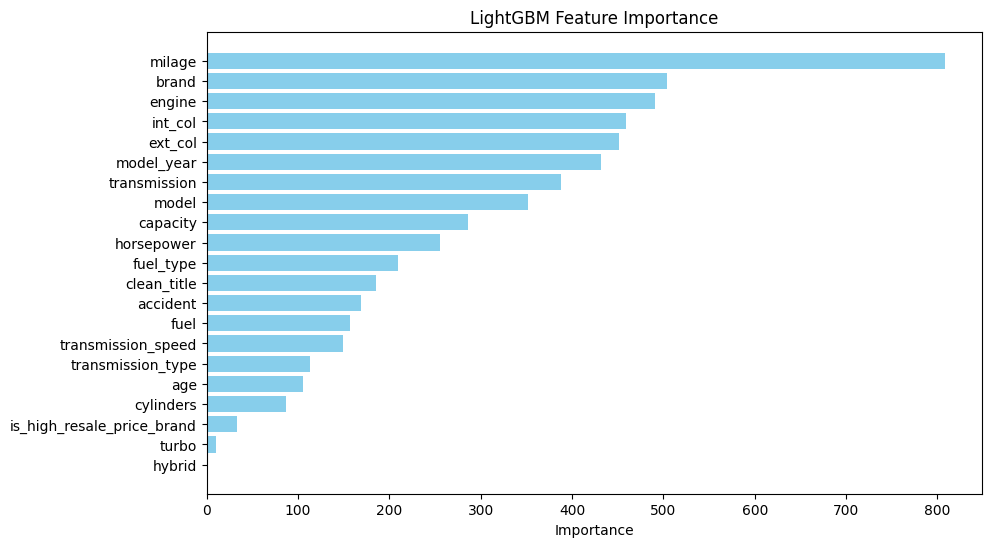

In [96]:
def get_feature_importance(model_name, model):
    if model_name == enums.ModelName.CatBoost:
        return model.get_feature_importance()
    if model_name == enums.ModelName.LGBM:
        return model.feature_importances_

# Get feature importance
model = fold_metrics_model[0][1]
# Create a DataFrame for visualization
df_feature_imp = pd.DataFrame({
    'f_name': feature_cols,
    'f_imp': get_feature_importance(Config.MODEL_TYPE, model)
})
# Sort the DataFrame by importance
df_feature_imp = df_feature_imp.sort_values(by='f_imp', ascending=False)
#data_utils.plot_feature_importance(df_feature_imp)
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_feature_imp['f_name'], df_feature_imp['f_imp'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'{Config.MODEL_TYPE} Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [ ]:
import shap

# Assume `model` is a trained model and `X_train` is the training data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train[feature_cols])
shap_interaction_values = explainer.shap_interaction_values(df_train[feature_cols])

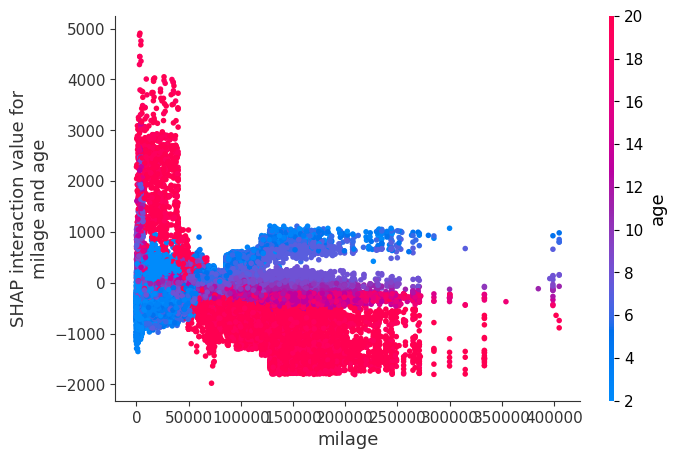

In [100]:
# Visualize interaction for two features
shap.dependence_plot(('milage', 'age'), shap_interaction_values, df_train[feature_cols])

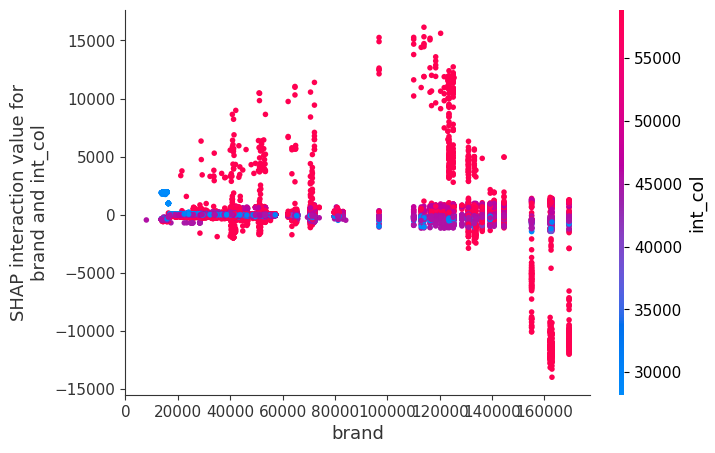

In [98]:
# Visualize interaction for two features
shap.dependence_plot(('brand', 'int_col'), shap_interaction_values, df_train[feature_cols])

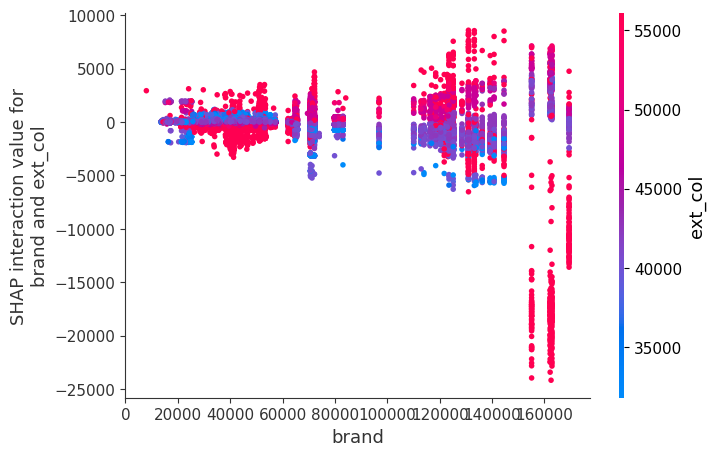

In [105]:
shap.dependence_plot(('brand', 'ext_col'), shap_interaction_values, df_train[feature_cols])

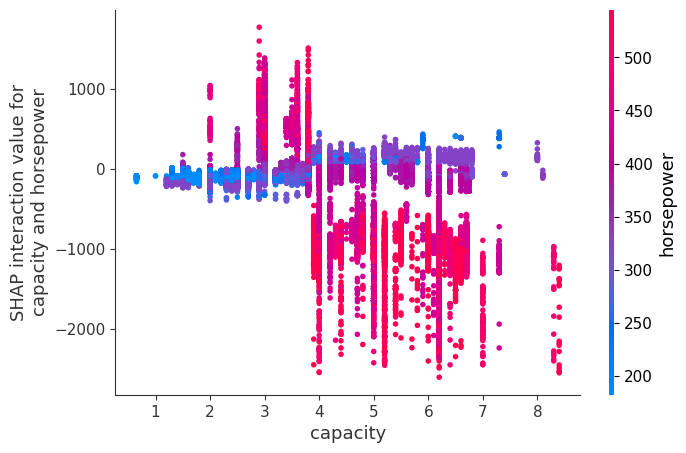

In [103]:
shap.dependence_plot(('capacity', 'horsepower'), shap_interaction_values, df_train[feature_cols])

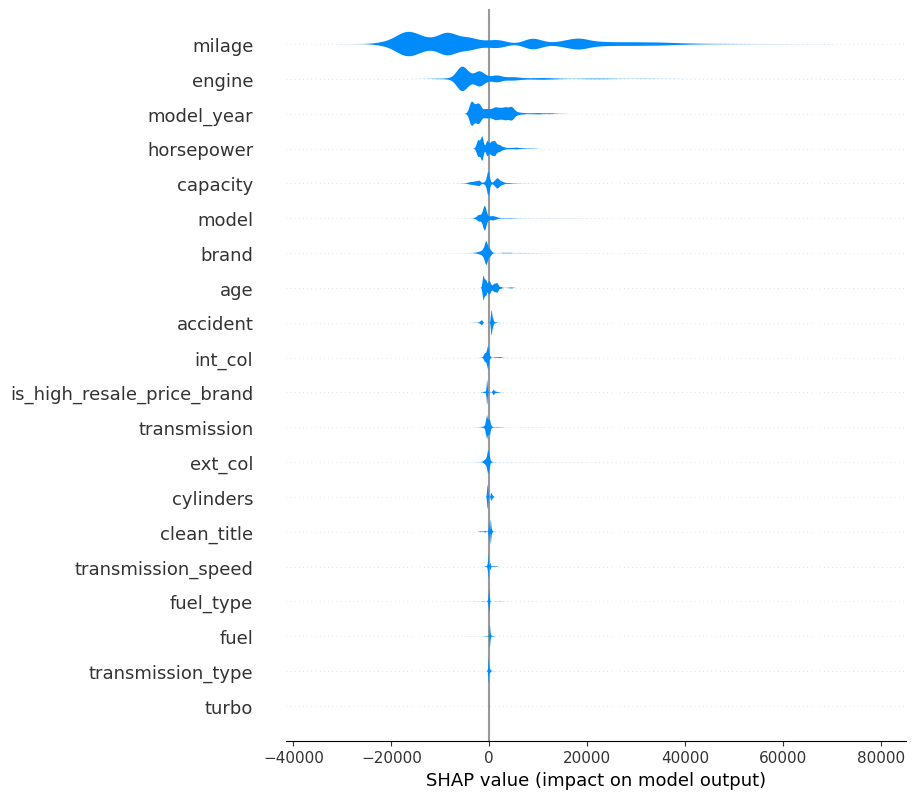

In [110]:
shap.plots.violin(shap_values, feature_names=feature_cols)

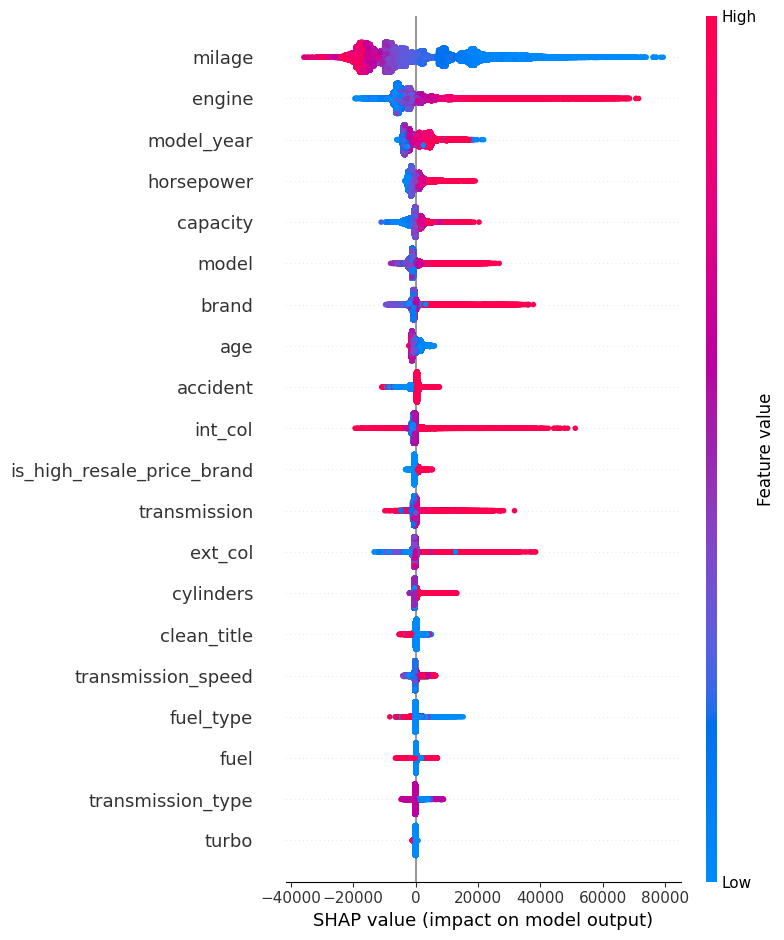

In [106]:
shap.summary_plot(shap_values, df_train[feature_cols])